<a href="https://colab.research.google.com/github/ETorresSacha/Analisis-de-datos/blob/main/analisis_datos_reto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os
from google.colab import files
import seaborn as sns
from sklearn import  preprocessing
import random

In [ ]:
# Descargar el archivo
# Guardar en Excel
t.to_excel("data_C311.xlsx", index=False)
files.download('data_C311.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ANÁLISIS DE DATOS DEL RUL
### TABLA TELEMETRÍA Y ALERTAS

In [2]:
uploaded = files.upload()

Saving rul_potenciaa.xlsx to rul_potenciaa.xlsx


In [ ]:
# para borrar los datos que se sucbió
os.remove("CAEX_RUL4.xlsx")

In [221]:
data = pd.read_excel(io.BytesIO(uploaded['rul_potenciaa.xlsx']))

/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [222]:
# vamos a crear los ciclos por cada equipo

# Ordenamos primero por equipo y fecha
data = data.sort_values(by=['equipment','fecha_telemetria'])

# Definimos el inicio de un nuevo ciclo cuando:
# - cambia el equipo
# - o el RUL vuelve a subir (después de llegar a 0)
data["new_cycle"] = (
    (data["equipment"] != data["equipment"].shift()) |   # cambio de equipo
    (data["RUL_Horas"] > data["RUL_Horas"].shift())            # RUL "reinicia"
).astype(int)

# Ahora creamos un contador acumulativo de ciclos dentro de cada equipo
data["Ciclo"] = data.groupby("equipment")["new_cycle"].cumsum()

# Eliminamos la columna auxiliar
data = data.drop(columns=["new_cycle"])

# Mover columna Ciclo a la posición 1
col = data.pop("Ciclo")            # sacar la columna
data.insert(5, "Ciclo", col)       # insertarla en la posición 5

In [223]:
data = data.drop(columns=['rn'])

In [190]:
# ÚTIL PARA CUANDO EVALUAMOS E COMPORTAMIENTO DE LAS VARIABLES RESPECTO A CADA EQUIPO, Y ASI DETERMINAR LOS EQUIPOS CON MEJORES DATOS

# calcularemos la importancia de las variables (features) ---! esto es útil pero lo colocaremos en el orden que corresponde cuando se arme el archivo final !!!!!!
from sklearn.ensemble import RandomForestRegressor

X = t.drop(columns=["RUL_Horas"])
y = t["RUL_Horas"]

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X, y)

importancess = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

importancess.head(20)

# DESPUÉS DE EVALUAR LOS DATOS DE CADA EQUIPO, NOS QUEDAMOS CON LOS EQUIPOS: 314,311,332 EN ESE ORDEN

,feature,importance
4,Ambient_Temp_Min,0.257166
0,horometro,0.248240
3,Ambient_Temp_Max,0.202257
2,Ambient_Temp_Ave,0.042721
1,Ciclo,0.037640
25,Engine_Coolant_Temp_Max,0.035840
6,Blow_by_Press_Max,0.023069
11,Brake_Oil_Temp_LF_Max,0.013091
32,Exhaust_Temp_Max_RR,0.009221
10,Brake_Oil_Temp_LF_Ave,0.008647


In [224]:
# Tomamos los datos de las variables mas relevantes para el análisis de falla de potencia
data =data[['equipment','RUL_Horas','horometro','Ciclo','Engine_Oil_Filter_Differential_Pressure','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max',
          'DC_Power_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min']]

In [225]:
# Seleccionamos los equipos mas relevantes (3 equipos)
data= data[data["equipment"].isin(["C314","C311","C332"])]

In [227]:
data = data.reset_index(drop=True)
data.head()

,equipment,RUL_Horas,horometro,Ciclo,Engine_Oil_Filter_Differential_Pressure,Eng_Oil_Press_Lo_Idle_Min,Eng_Oil_Press_Max,Eng_Oil_Temp_Max,DC_Power_Max,Engine_Coolant_Temp_Max,Eng_Oil_Press_Hi_Idle_Min
0,C311,2813,39255.6,1,400,200.0,690,92.0,2136,84,420.0
1,C311,2785,39275.6,1,390,210.0,680,91.0,2173,83,420.0
2,C311,2748,39295.6,1,860,210.0,740,92.0,2232,83,410.0
3,C311,2712,39315.6,1,720,210.0,720,95.0,2166,83,420.0
4,C311,2673,39335.6,1,620,200.0,690,96.0,2231,83,410.0


array([[<Axes: title={'center': 'RUL_Horas'}>,
        <Axes: title={'center': 'horometro'}>,
        <Axes: title={'center': 'Ciclo'}>],
       [<Axes: title={'center': 'Engine_Oil_Filter_Differential_Pressure'}>,
        <Axes: title={'center': 'Eng_Oil_Press_Lo_Idle_Min'}>,
        <Axes: title={'center': 'Eng_Oil_Press_Max'}>],
       [<Axes: title={'center': 'Eng_Oil_Temp_Max'}>,
        <Axes: title={'center': 'DC_Power_Max'}>,
        <Axes: title={'center': 'Engine_Coolant_Temp_Max'}>],
       [<Axes: title={'center': 'Eng_Oil_Press_Hi_Idle_Min'}>, <Axes: >,
        <Axes: >]], dtype=object)

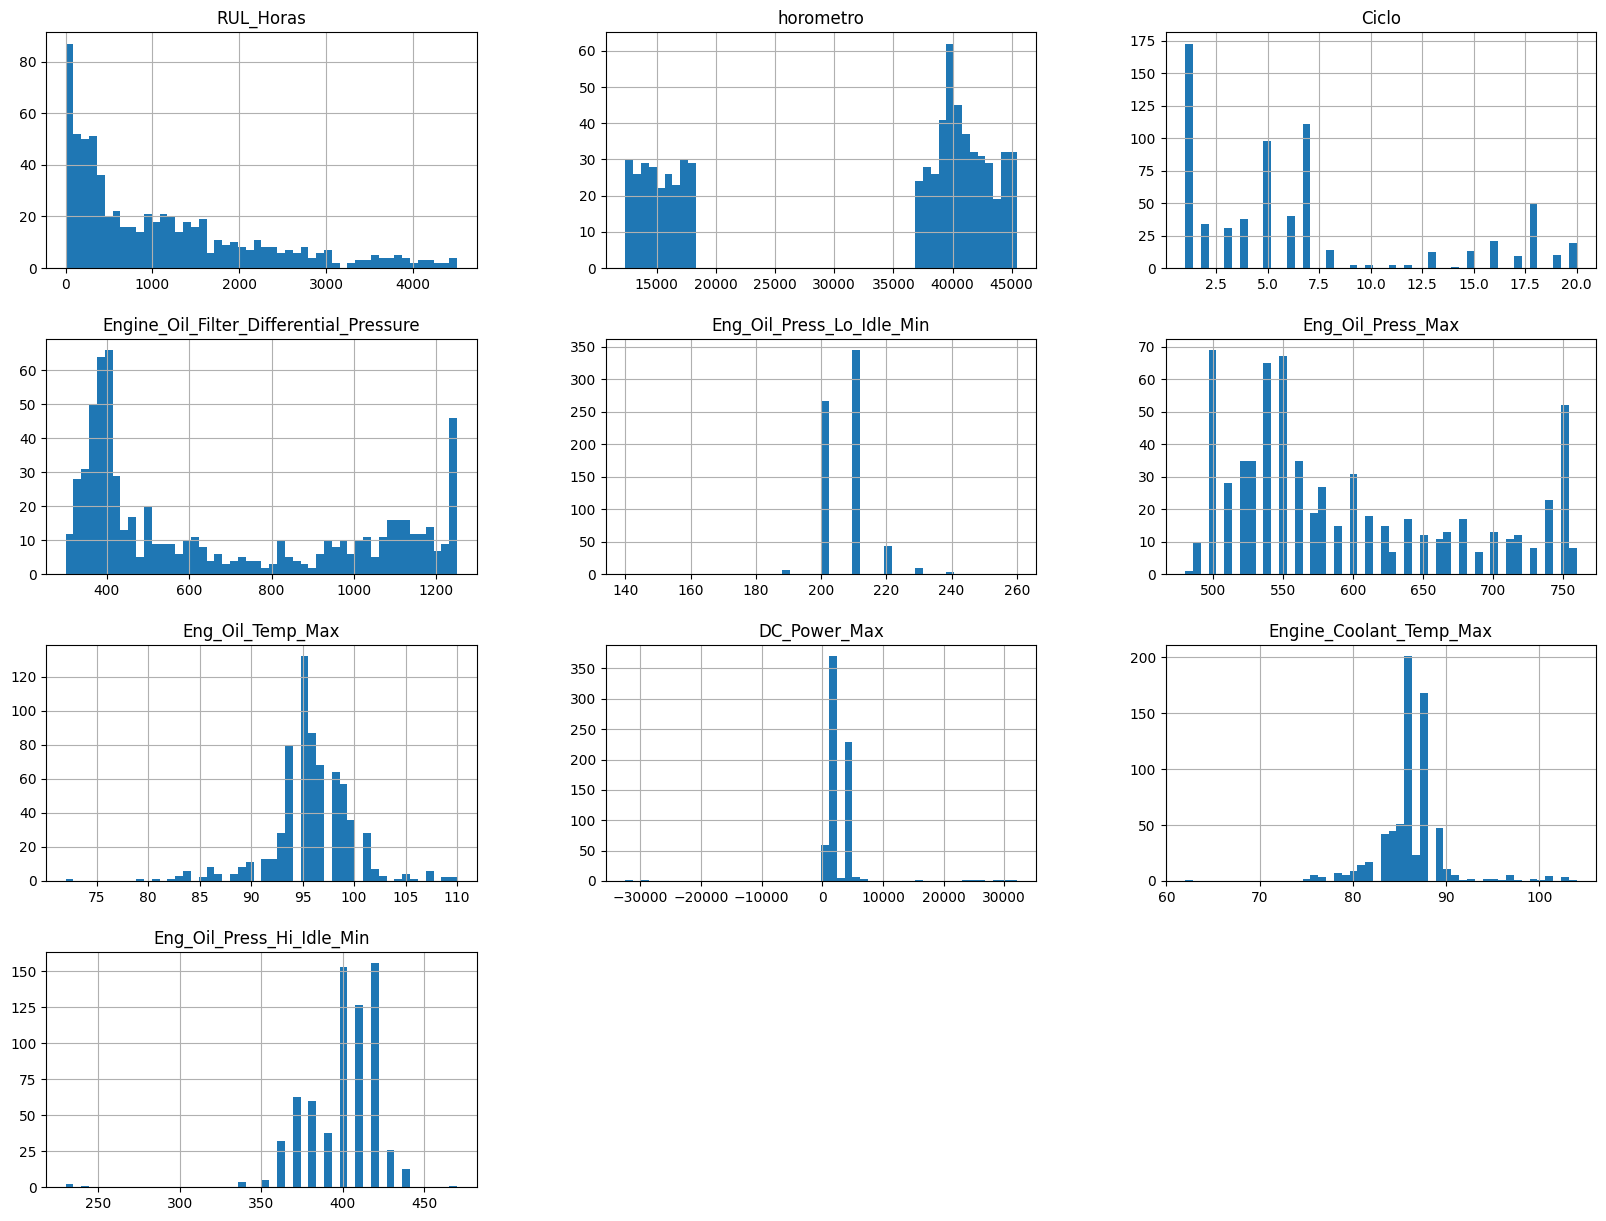

In [228]:
# visualización de los datos en histograms
data.hist(bins=50, figsize=(20,15))

<Axes: >

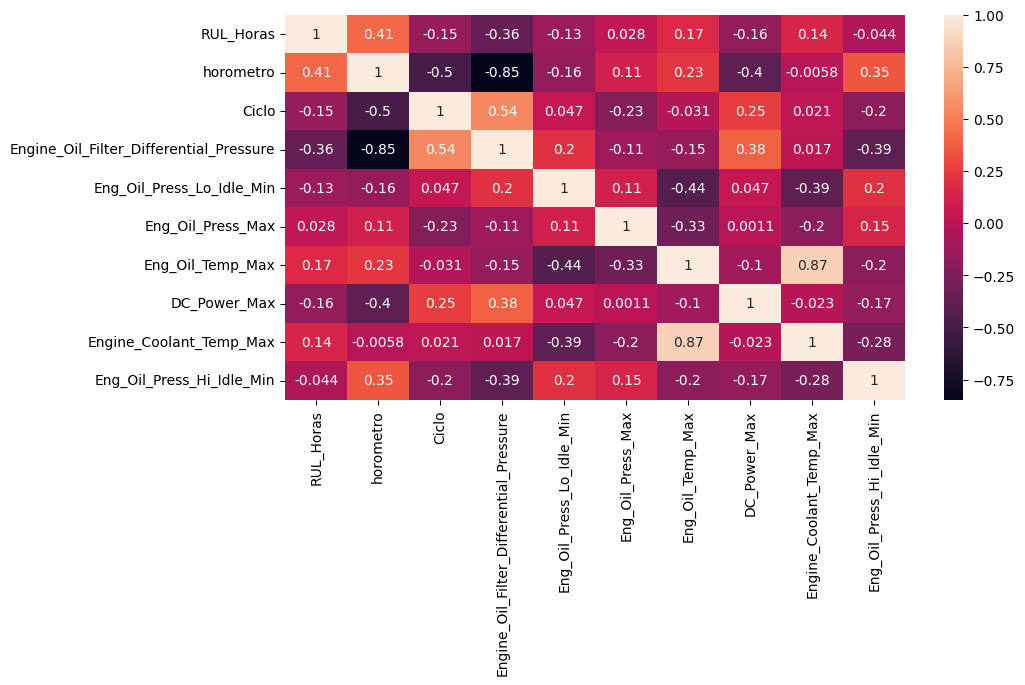

In [209]:
# Correlación
plt.figure(figsize=(10,5))
# Filtrar solo las columnas numéricas
numeric_data = data.select_dtypes(include='number')

# Crear el heatmap
sns.heatmap(numeric_data.corr(), annot=True)
plt.show()

In [213]:
# Informacion de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 681 entries, 1432 to 5472
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   equipment                                681 non-null    object 
 1   RUL_Horas                                681 non-null    int64  
 2   horometro                                681 non-null    float64
 3   Ciclo                                    681 non-null    int64  
 4   Engine_Oil_Filter_Differential_Pressure  681 non-null    int64  
 5   Eng_Oil_Press_Lo_Idle_Min                681 non-null    float64
 6   Eng_Oil_Press_Max                        681 non-null    int64  
 7   Eng_Oil_Temp_Max                         681 non-null    float64
 8   DC_Power_Max                             681 non-null    int64  
 9   Engine_Coolant_Temp_Max                  681 non-null    int64  
 10  Eng_Oil_Press_Hi_Idle_Min                681 non-nu

In [229]:
# Completamos los valores faltantes con la mediana
data['Eng_Oil_Press_Lo_Idle_Min'] = data['Eng_Oil_Press_Lo_Idle_Min'].fillna(data['Eng_Oil_Press_Lo_Idle_Min'].median())

### Convertimos los datos categoricos a numéricos

In [230]:
from sklearn.preprocessing import OneHotEncoder
data_equipment = data[['equipment']]
cat_encoder = OneHotEncoder()
data_car_1hot = cat_encoder.fit_transform(data_equipment)

In [231]:
# Visualizar los datos categóricos
encoded_df = pd.DataFrame(data_car_1hot.toarray(), columns=cat_encoder.get_feature_names_out())
encoded_df

,equipment_C311,equipment_C314,equipment_C332
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
676,0.0,0.0,1.0
677,0.0,0.0,1.0
678,0.0,0.0,1.0
679,0.0,0.0,1.0


### Creamos los datos para Machine Learning

In [328]:
# Variables dependientes e independientes
y = data['RUL_Horas']
x = data[['horometro','Ciclo','Engine_Oil_Filter_Differential_Pressure','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max',
          'DC_Power_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min']]
x

,horometro,Ciclo,Engine_Oil_Filter_Differential_Pressure,Eng_Oil_Press_Lo_Idle_Min,Eng_Oil_Press_Max,Eng_Oil_Temp_Max,DC_Power_Max,Engine_Coolant_Temp_Max,Eng_Oil_Press_Hi_Idle_Min
0,39255.6,1,400,200.0,690,92.0,2136,84,420.0
1,39275.6,1,390,210.0,680,91.0,2173,83,420.0
2,39295.6,1,860,210.0,740,92.0,2232,83,410.0
3,39315.6,1,720,210.0,720,95.0,2166,83,420.0
4,39335.6,1,620,200.0,690,96.0,2231,83,410.0
...,...,...,...,...,...,...,...,...,...
676,18170.2,20,1120,200.0,540,95.0,4283,86,360.0
677,18190.2,20,1130,200.0,540,95.0,4235,86,360.0
678,18210.2,20,1190,210.0,630,94.0,4143,86,360.0
679,18270.2,20,1250,200.0,550,95.0,4325,86,360.0


In [329]:
# concadenamos los valores independientes(valores de los sensores) con las variable categóricas(equipment)
data_concadenado= pd.concat([x,encoded_df],axis=1)  # unimos los datos cateoricos  co los datos independientes
data_concadenado.head()

,horometro,Ciclo,Engine_Oil_Filter_Differential_Pressure,Eng_Oil_Press_Lo_Idle_Min,Eng_Oil_Press_Max,Eng_Oil_Temp_Max,DC_Power_Max,Engine_Coolant_Temp_Max,Eng_Oil_Press_Hi_Idle_Min,equipment_C311,equipment_C314,equipment_C332
0,39255.6,1,400,200.0,690,92.0,2136,84,420.0,1.0,0.0,0.0
1,39275.6,1,390,210.0,680,91.0,2173,83,420.0,1.0,0.0,0.0
2,39295.6,1,860,210.0,740,92.0,2232,83,410.0,1.0,0.0,0.0
3,39315.6,1,720,210.0,720,95.0,2166,83,420.0,1.0,0.0,0.0
4,39335.6,1,620,200.0,690,96.0,2231,83,410.0,1.0,0.0,0.0


In [330]:
# Tomamos los valores de data_concadenado y los asignamos a "x"
x= data_concadenado

# ENTRENAMIENTO CON MACHINE LEARNING
## Bosques aleatorios

In [331]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)

# Entrenar Random Forest

#model = RandomForestRegressor()
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)


# Evaluar métricas

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('\n**** MÉTRICAS ****')
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print('******************')



**** MÉTRICAS ****
MAE: 129.29
MSE: 60954.10
RMSE: 246.89
R²: 0.9355
******************


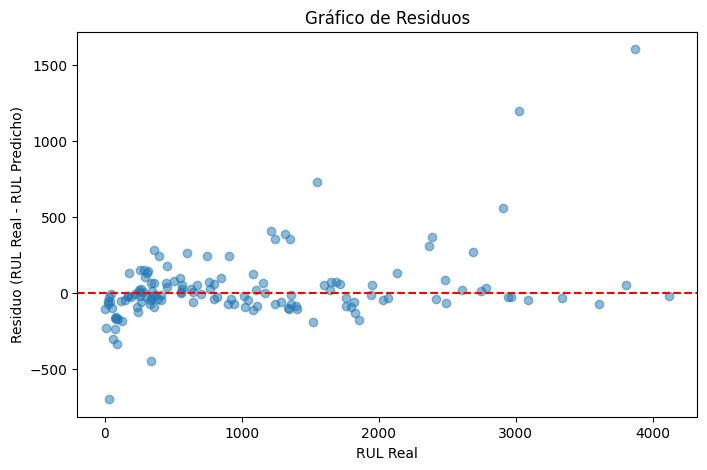

In [288]:
import matplotlib.pyplot as plt
import numpy as np

# Asegurar vectores 1D
y_test = np.ravel(y_test)   # convierte (n,1) -> (n,)
y_pred = np.ravel(y_pred)   # por si acaso

# Calcular residuos
residuos = y_test - y_pred

# Crear gráfico de dispersión
plt.figure(figsize=(8,5))
plt.scatter(y_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel("RUL Real")
plt.ylabel("Residuo (RUL Real - RUL Predicho)")
plt.title("Gráfico de Residuos")
plt.show()


In [334]:
import pandas as pd

# Supongamos que tienes tus datos de prueba con los equipos
# X_test todavía contiene la columna 'equipo'
# y_test son los valores reales (RUL real)
# y_pred son los valores predichos por el modelo

# Creamos un DataFrame con equipo, valor real y valor predicho
resultados = pd.DataFrame({
    "Equipo": X_test["equipment_C311"].iloc[6:12].values,   # equipo al que pertenece
    "RUL Real": y_test[6:12],                       # valores reales
    "RUL Predicción": y_pred[6:12],                 # valores predichos
    "Diferencia": y_test[6:12] - y_pred[6:12]       # error de predicción
})

print(resultados)


     Equipo  RUL Real  RUL Predicción  Diferencia
286     0.0      2492         2561.17      -69.17
340     0.0       219          200.44       18.56
311     0.0      1358         1430.66      -72.66
631     0.0       702          718.40      -16.40
529     0.0        26           73.74      -47.74
210     1.0      1795         1888.74      -93.74


In [326]:
import pandas as pd

# Paso 1: Aseguramos que y_test y y_pred sean arrays planos
y_test = pd.Series(y_test).reset_index(drop=True)
y_pred = pd.Series(y_pred).reset_index(drop=True)

# Paso 2: Creamos el DataFrame de resultados
resultados = pd.DataFrame({
   # "Equipo": X_test.reset_index(drop=True)["equipment"].iloc[6:12],
    "RUL Real": y_test.iloc[6:12],
    "RUL Predicción": y_pred.iloc[6:12],
})

# Paso 3: Agregamos la diferencia
resultados["Diferencia"] = resultados["RUL Real"] - resultados["RUL Predicción"]

print(resultados)


    RUL Real  RUL Predicción  Diferencia
6       2492         2561.17      -69.17
7        219          200.44       18.56
8       1358         1430.66      -72.66
9        702          718.40      -16.40
10        26           73.74      -47.74
11      1795         1888.74      -93.74


In [324]:


# Recuperar el equipo real a partir del one-hot
equipos = encoded_df.filter(like="equipment_C311").idxmax(axis=1)
# equipos = equipos.str.replace("equipment_C311", "")
# equipos
equipos

,0
0,equipment_C311
1,equipment_C311
2,equipment_C311
3,equipment_C311
4,equipment_C311
...,...
676,equipment_C311
677,equipment_C311
678,equipment_C311
679,equipment_C311


In [325]:
X_test

array([[1.75702e+04, 1.80000e+01, 1.08000e+03, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [3.75450e+04, 1.00000e+00, 3.70000e+02, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [4.06556e+04, 1.00000e+00, 4.20000e+02, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [4.41755e+04, 7.00000e+00, 3.40000e+02, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.48704e+04, 1.30000e+01, 8.00000e+02, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [4.10249e+04, 5.00000e+00, 1.25000e+03, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00]])

In [320]:
# Reconstruir X_test con nombres
pd.DataFrame(X_test)

# Recuperar el equipo real a partir del one-hot
equipos = X_test_df.filter(like="equipment_C314").idxmax(axis=1)
equipos = equipos.str.replace("equipment_C314", "")

resultados = pd.DataFrame({
    "Equipo": equipos.iloc[:10].values,  # ahora sí sale "C311"
    "RUL Real": y_test[:10],
    "RUL Predicción": y_pred[:10],
    "Diferencia": (y_test[:10] - y_pred[:10])
})


,0,1,2,3,4,5,6,7,8,9,10,11
0,17570.2,18.0,1080.0,210.0,610.0,95.0,4046.0,86.0,420.0,0.0,0.0,1.0
1,37545.0,1.0,370.0,200.0,580.0,98.0,2273.0,89.0,400.0,0.0,1.0,0.0
2,40655.6,1.0,420.0,200.0,710.0,94.0,2137.0,85.0,410.0,1.0,0.0,0.0
3,38085.0,1.0,490.0,210.0,580.0,97.0,2074.0,88.0,390.0,0.0,1.0,0.0
4,41595.5,3.0,390.0,220.0,750.0,84.0,2147.0,78.0,440.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
132,41135.6,2.0,380.0,210.0,720.0,92.0,3.0,82.0,410.0,1.0,0.0,0.0
133,40315.6,1.0,640.0,210.0,660.0,95.0,2259.0,85.0,410.0,1.0,0.0,0.0
134,44175.5,7.0,340.0,210.0,510.0,99.0,3.0,89.0,410.0,1.0,0.0,0.0
135,14870.4,13.0,800.0,210.0,700.0,93.0,4256.0,86.0,420.0,0.0,0.0,1.0


In [312]:
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
resultados = pd.DataFrame({
    "Equipo": X_test["equipment_C311"].iloc[:10].values,
    "RUL Real": y_test[:10].ravel(),
    "RUL Predicción": y_pred[:10].ravel(),
    "Diferencia": (y_test[:10] - y_pred[:10]).ravel()
})
print(resultados)

   RUL Real  RUL Predicción  Diferencia
0       125          301.57     -176.57
1      1947         1878.87       68.13
2       555          559.85       -4.85
3      1113         1200.86      -87.86
4         4          103.07      -99.07
5       292          185.38      106.62
6      2492         2561.17      -69.17
7       219          200.44       18.56
8      1358         1430.66      -72.66
9       702          718.40      -16.40


In [181]:
data_C314 = data[data['equipment'] == 'C314']
# SERÁ ELIMNADO, SOLO ES PARA HACER LA PRUEBAS
t=data_C314.copy()

t = t.iloc[:,3:]

In [307]:
print(type(X_test))
print(type(y_test))
print(type(y_pred))

print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(137, 12)
(137,)
(137,)


In [105]:
#numeric_data = data.select_dtypes(include='number')
corr_matrix = t.corr()
corr_matrix['RUL_Horas'].sort_values(ascending=False)

,RUL_Horas
RUL_Horas,1.000000
Exhaust_Temp_Max_RR,0.315179
Exhaust_Temp_Max_LR,0.272766
Ciclo,0.272610
Motor_Torque_B_at_Retard_Mode_Ave,0.178530
Motor_Torque_A_at_Retard_Mode_Ave,0.177847
Exhaust_Temp_Max_RF,0.159908
Ambient_Temp_Max,0.105578
Engine_Speed_Max,0.097649
Motor_A_Power_Max,0.094785


In [96]:
t.columns

Index(['RUL_Horas', 'horometro', 'Ciclo', 'Ambient_Temp_Ave',
       'Ambient_Temp_Max', 'Ambient_Temp_Min', 'Atmos_Pres_Ave',
       'Blow_by_Press_Max', 'Boost_LB_Press_Max', 'Boost_RB_Press_Max',
       'BRAKE_ENERGY', 'Brake_Oil_Temp_LF_Ave', 'Brake_Oil_Temp_LF_Max',
       'Brake_Oil_Temp_LR_Ave', 'Brake_Oil_Temp_LR_Max',
       'Brake_Oil_Temp_RF_Ave', 'Brake_Oil_Temp_RF_Max',
       'Brake_Oil_Temp_RR_Ave', 'Brake_Oil_Temp_RR_Max', 'Brake_Power_Max',
       'DC_Power_Ave', 'DC_Power_Max', 'Eng_Oil_Press_Hi_Idle_Min',
       'Eng_Oil_Press_Lo_Idle_Min', 'Eng_Oil_Temp_Max', 'Eng_Oil_Press_Max',
       'Engine_Coolant_Temp_Max', 'Engine_Coolant_Temp_Min',
       'Engine_Oil_Filter_Differential_Pressure', 'Engine_Speed_Max',
       'Exhaust_Temp_Max_LF', 'Exhaust_Temp_Max_LR', 'Exhaust_Temp_Max_RF',
       'Exhaust_Temp_Max_RR', 'Fuel_Rate_Ave', 'Hoist_Press1_Max',
       'Hoist_Press2_Max', 'Motor_A_Power_Max', 'Motor_A_Power_Ave',
       'Motor_A_Torque_Ave', 'Motor_A_Torque_Max',

# pruebas

In [180]:
# Seleccionamos el tipo de equipo
data_C314 = data[data['equipment'] == 'C314']
# SERÁ ELIMNADO, SOLO ES PARA HACER LA PRUEBAS
t=data_C314.copy()

t = t.iloc[:,3:]
# Reemplazar todos los NaN por 0
#t = t.fillna(0)
t = t[['RUL_Horas', 'horometro','Ciclo','Engine_Oil_Filter_Differential_Pressure','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Hi_Idle_Min',
               'Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max',
               'Motor_A_Power_Max','Motor_B_Power_Max','DC_Power_Max']]

t.reset_index(drop=True)

,RUL_Horas,horometro,Ciclo,Engine_Oil_Filter_Differential_Pressure,Eng_Oil_Press_Lo_Idle_Min,Eng_Oil_Press_Hi_Idle_Min,Eng_Oil_Press_Max,Eng_Oil_Temp_Max,Engine_Coolant_Temp_Max,Motor_A_Power_Max,Motor_B_Power_Max,DC_Power_Max
0,3047,37005.0,1,450,220.0,410.0,580,93.0,85,992.0,994.0,2179
1,3023,37025.0,1,740,210.0,400.0,600,93.0,83,989.0,1004.0,2112
2,3000,37045.0,1,620,210.0,410.0,600,94.0,86,989.0,999.0,2172
3,2976,37065.0,1,450,220.0,400.0,600,94.0,84,990.0,1012.0,2259
4,2929,37085.0,1,500,220.0,400.0,690,95.0,85,1019.0,986.0,2158
...,...,...,...,...,...,...,...,...,...,...,...,...
163,248,40964.9,5,1250,210.0,420.0,530,99.0,88,975.0,1005.0,2214
164,226,40984.9,5,1000,210.0,430.0,510,101.0,89,1018.0,995.0,2103
165,67,41004.9,5,1250,210.0,430.0,720,101.0,89,1015.0,999.0,2125
166,30,41024.9,5,1250,210.0,410.0,630,102.0,88,978.0,1025.0,4898


In [164]:
#numeric_data = data.select_dtypes(include='number')
corr_matrix = t.corr()
corr_matrix['RUL_Horas'].sort_values(ascending=False)

,RUL_Horas
RUL_Horas,1.000000
Ciclo,0.502819
horometro,0.469799
Engine_Oil_Filter_Differential_Pressure,0.159193
Eng_Oil_Press_Lo_Idle_Min,0.046944
Eng_Oil_Press_Max,0.013827
Eng_Oil_Temp_Max,-0.026068
Motor_B_Power_Max,-0.039159
DC_Power_Max,-0.053003
Engine_Coolant_Temp_Max,-0.055055


# machine

In [185]:
# ANALIZAMOS EL COMPORAMIENTO DE LAS METRICAS POR CADA VARIABLE

# columnas = ['horometro','Ciclo','Engine_Oil_Filter_Differential_Pressure','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Hi_Idle_Min',
#                'Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max',
#                'Motor_A_Power_Max','Motor_B_Power_Max','DC_Power_Max']

columnas=['horometro','Ciclo','Engine_Oil_Filter_Differential_Pressure','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max',
          'DC_Power_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min']
# columnas = [ 'horometro','Ciclo','Engine_Oil_Filter_Differential_Pressure','Eng_Oil_Press_Lo_Idle_Min',
#  'Eng_Oil_Press_Hi_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max','Exhaust_Temp_Max_RF',
#  'Exhaust_Temp_Max_LF','Exhaust_Temp_Max_RR','Exhaust_Temp_Max_LR','Blow_by_Press_Max','Motor_A_Power_Max',
#  'Motor_B_Power_Max','DC_Power_Ave','Motor_A_Power_Ave','Motor_B_Power_Ave','Motor_A_Torque_Max','Motor_B_Torque_Max',
#  'Motor_A_Torque_Ave','Motor_B_Torque_Ave','Motor_Power_A_at_Retard_Mode_Max','Motor_Power_B_at_Retard_Mode_Max',
#  'Motor_Torque_A_at_Retard_Mode_Max','Motor_Torque_B_at_Retard_Mode_Max']

col_modelo = []
y = t["RUL_Horas"].values
for col in columnas:
  col_modelo.append(col)
  data1 = t[col_modelo]
 # data1 = pd.concat([data1,encoded_df],axis=1) # encoded_df, se encuentra en la parte superior -- esta concadenando con los valores de OneHotEncoder
  x = data1.values

  # dividir los valores para el entrenamiento y testear los datos
  x_train,x_test,y_train,y_test = train_test_split(x,y , test_size=0.2,  random_state=42)
  # llamamos a la regresión
  forest_reg = RandomForestRegressor(
          n_estimators=100,
          random_state=42,
          n_jobs=-1
  )
  # entrenamiento
  forest_reg.fit(x_train, y_train)
  #predicción
  y_pred = forest_reg.predict(x_test)
  r2 = r2_score(y_test,y_pred)
  print(col_modelo,r2)




['horometro'] 0.9977774390524214
['horometro', 'Ciclo'] 0.9981546711762308
['horometro', 'Ciclo', 'Engine_Oil_Filter_Differential_Pressure'] 0.9968092061248743
['horometro', 'Ciclo', 'Engine_Oil_Filter_Differential_Pressure', 'Eng_Oil_Press_Lo_Idle_Min'] 0.9969190178624281
['horometro', 'Ciclo', 'Engine_Oil_Filter_Differential_Pressure', 'Eng_Oil_Press_Lo_Idle_Min', 'Eng_Oil_Press_Max'] 0.9965238731053239
['horometro', 'Ciclo', 'Engine_Oil_Filter_Differential_Pressure', 'Eng_Oil_Press_Lo_Idle_Min', 'Eng_Oil_Press_Max', 'Eng_Oil_Temp_Max'] 0.9947070758430239
['horometro', 'Ciclo', 'Engine_Oil_Filter_Differential_Pressure', 'Eng_Oil_Press_Lo_Idle_Min', 'Eng_Oil_Press_Max', 'Eng_Oil_Temp_Max', 'DC_Power_Max'] 0.9929243472898173
['horometro', 'Ciclo', 'Engine_Oil_Filter_Differential_Pressure', 'Eng_Oil_Press_Lo_Idle_Min', 'Eng_Oil_Press_Max', 'Eng_Oil_Temp_Max', 'DC_Power_Max', 'Engine_Coolant_Temp_Max'] 0.9923631959745182
['horometro', 'Ciclo', 'Engine_Oil_Filter_Differential_Pressure', '

In [176]:

# Crear un DataFrame con Reales y Predicciones
resultados = pd.DataFrame({
    "RUL Real": y_test[6:12],        # sin .values porque ya es ndarray
    "RUL Predicción": y_pred[6:12]   # y_pred también es ndarray
})

print(resultados)


   RUL Real  RUL Predicción
0      1360         1302.35
1       619          390.75
2       240          259.57
3       400          452.00
4      2775         2233.42
5      1680         1685.49


In [93]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Dividimos las variables

# Seleccionar solo columnas numéricas
#numeric_cols = t.select_dtypes(include=['number']).columns

# Eliminar 'RUL' y 'horometro' de X
x = t.drop(columns=['RUL_Horas'], errors='ignore')
y = t["RUL_Horas"]

# Dividir en train y test


X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)

# Entrenar Random Forest

#model = RandomForestRegressor()
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar métricas

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


MAE: 180.30
MSE: 56910.82
RMSE: 238.56
R²: 0.9805


In [21]:
# ANALIZAMOS EL COMPORAMIENTO DE LAS METRICAS POR CADA VARIABLE


# Seleccionar solo columnas numéricas
numeric_cols = t.select_dtypes(include=['number']).columns

# Eliminar 'RUL' y 'horometro' de X
X = t[numeric_cols].drop(columns=['RUL_Horas'], errors='ignore')
y = t["RUL_Horas"]

# columnas = ['RUL_Horas','Ciclo','Engine_Oil_Filter_Differential_Pressure','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Hi_Idle_Min',
#                'Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max',
#                'Motor_A_Power_Max','Motor_B_Power_Max','DC_Power_Max']
# col_modelo = []
# y = t["RUL_Horas"].values
# for col in columnas:
#   col_modelo.append(col)
#   data1 = t[col_modelo]
#  # data1 = pd.concat([data1,encoded_df],axis=1) # encoded_df, se encuentra en la parte superior -- esta concadenando con los valores de OneHotEncoder
#   x = data1.values

# dividir los valores para el entrenamiento y testear los datos
x_train,x_test,y_train,y_test = train_test_split(x,y , test_size=0.2 )
# llamamos a la regresión
forest_reg = RandomForestRegressor()
# entrenamiento
forest_reg.fit(x_train, y_train)
#predicción
y_pred = forest_reg.predict(x_test)


r2 = r2_score(y_test,y_pred)
print(col_modelo,r2)


# Evaluar métricas

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


['RUL_Horas', 'Ciclo', 'Engine_Oil_Filter_Differential_Pressure', 'Eng_Oil_Press_Lo_Idle_Min', 'Eng_Oil_Press_Hi_Idle_Min', 'Eng_Oil_Press_Max', 'Eng_Oil_Temp_Max', 'Engine_Coolant_Temp_Max', 'Motor_A_Power_Max', 'Motor_B_Power_Max', 'DC_Power_Max'] 0.9992883919998912
R²: 0.9993
MAE: 6.82
MSE: 142.53
RMSE: 11.94
R²: 0.9993


In [177]:

# Crear un DataFrame con Reales y Predicciones
resultados = pd.DataFrame({
    "RUL Real": y_test[6:12],        # sin .values porque ya es ndarray
    "RUL Predicción": y_pred[6:12],  # y_pred también es ndarray
    "Diferencia: ": y_test[6:12]-y_pred[6:12]
})

print(resultados)


   RUL Real  RUL Predicción  Diferencia: 
0      1360         1302.35         57.65
1       619          390.75        228.25
2       240          259.57        -19.57
3       400          452.00        -52.00
4      2775         2233.42        541.58
5      1680         1685.49         -5.49


In [14]:
import pandas as pd
import numpy as np

# Crear un DataFrame con valores aleatorios
resultados = pd.DataFrame({
    "RUL Real": np.random.randint(100, 500, size=5),        # enteros aleatorios entre 100 y 500
    "RUL Predicción": np.random.randint(100, 500, size=5)   # enteros aleatorios entre 100 y 500
})

print(resultados)


   RUL Real  RUL Predicción
0       278             149
1       468             357
2       345             384
3       458             465
4       267             343


# parece que esta forma de codigo esta super mejor, analizarlo y si es necesario implementarlo con todo. lo que esta arriba

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Dividimos las variables

# Seleccionar solo columnas numéricas
numeric_cols = t.select_dtypes(include=['number']).columns

# Eliminar 'RUL' y 'horometro' de X
X = t[numeric_cols].drop(columns=['RUL_Horas'], errors='ignore')
y = t["RUL_Horas"]

# Dividir en train y test


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

# Entrenar Random Forest

model = RandomForestRegressor()
# model = RandomForestRegressor(
#     n_estimators=200,
#     random_state=42,
#     n_jobs=-1
# )
model.fit(X_train, y_train)


# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar métricas

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


MAE: 180.30
MSE: 56910.82
RMSE: 238.56
R²: 0.6844


In [ ]:

# Crear un DataFrame con Reales y Predicciones
resultados = pd.DataFrame({
    "RUL Real": y_test[:5].values,
    "RUL Predicción": y_pred[:5]
})

print(resultados)


   RUL Real  RUL Predicción
0       341          336.43
1       353          293.35
2       292          361.75
3      1218          966.47
4      1043         1029.77


In [ ]:
# Clasificaremos los datos de los equipos que tienen mayor cantidad de mantenimientos: C333,C332,C331,C311 y C319
data = data[data['equipment'].isin(['C311', 'C324', 'C330', 'C321', 'C333'])]

###  Paso 1 – Exploración inicial de la data (EDA básico).

In [ ]:
# Vista rápida de la estructura
print("Dimensiones del dataset:", data.shape)
print("\nTipos de datos:")
print(data.dtypes)

Dimensiones del dataset: (5718, 59)

Tipos de datos:
equipment                                          object
fecha_telemetria                           datetime64[ns]
fecha_final                                datetime64[ns]
RUL_Horas                                           int64
horometro                                           int64
Ambient_Temp_Ave                                    int64
Ambient_Temp_Max                                  float64
Ambient_Temp_Min                                  float64
Atmos_Pres_Ave                                      int64
Blow_by_Press_Max                                 float64
Boost_LB_Press_Max                                  int64
Boost_RB_Press_Max                                float64
BRAKE_ENERGY                                        int64
Brake_Oil_Temp_LF_Ave                               int64
Brake_Oil_Temp_LF_Max                               int64
Brake_Oil_Temp_LR_Ave                               int64
Brake_Oil_Temp_LR_M

In [ ]:
# Distribución de equipos
print("\nCantidad de registros por ID de equipo:")
display(data['equipment'].value_counts())


Cantidad de registros por ID de equipo:


,count
equipment,
C311,270
C333,245
C332,243
C319,215
C331,185


In [ ]:
#Creamos una copia de los datos
data_filtrado = data.copy()

In [ ]:
# Ordenamos los datos, verificamos si existen filas completas con datos nulos
data_filtrado = data_filtrado.sort_values(by=['Ambient_Temp_Ave',	'Ambient_Temp_Max'], ascending= True, na_position='first')

In [ ]:
data_filtrado.head()

,equipment,fecha_telemetria,fecha_final,RUL_Horas,horometro,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Blow_by_Press_Max,...,Motor_Power_B_at_Retard_Mode_Ave,Motor_Power_B_at_Retard_Mode_Max,Motor_Torque_A_at_Retard_Mode_Ave,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,rn
5155,C331,2021-06-18 01:10:57,2021-06-20 03:29:00,50,14389,0,9.0,-6.0,60,NaN,...,621,2154.0,6620,20510.0,6580,21450.0,21536,2712,2718,1
5579,C333,2021-06-27 17:16:16,2021-07-10 20:24:00,315,13709,0,10.0,-10.0,60,NaN,...,864,2223.0,7770,20830.0,7800,23060.0,22252,2107,2114,1
5156,C331,2021-06-19 01:26:51,2021-06-20 03:29:00,26,14409,0,11.0,-6.0,60,NaN,...,541,2065.0,5810,21180.0,5790,21710.0,21366,2566,2561,1
5555,C333,2021-05-21 10:07:18,2021-05-23 23:18:00,61,13149,0,13.0,-10.0,60,NaN,...,765,2248.0,6850,21150.0,6860,20260.0,21957,2214,2196,1
5157,C331,2021-06-21 06:11:22,2021-06-23 06:57:00,48,14449,0,14.0,-5.0,60,NaN,...,750,2137.0,6950,21000.0,6920,20680.0,21452,2726,2733,1


In [ ]:
# Resumen estadístico de todas las columnas numéricas
print("\nResumen estadístico:")
display(data_filtrado.describe())


Resumen estadístico:


,fecha_telemetria,fecha_final,RUL_Horas,horometro,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Blow_by_Press_Max,Boost_LB_Press_Max,...,Motor_Power_B_at_Retard_Mode_Ave,Motor_Power_B_at_Retard_Mode_Max,Motor_Torque_A_at_Retard_Mode_Ave,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,rn
count,1158,1158,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,485.000000,1158.000000,...,1158.000000,1099.000000,1158.000000,1099.000000,1158.000000,1099.000000,1158.000000,1158.000000,1158.000000,1158.0
mean,2021-07-29 17:22:46.502590464,2021-09-06 22:53:51.243523328,941.485320,25777.414508,12.520725,27.328152,2.531088,59.419689,1.832990,261.917098,...,784.105354,2214.587807,7066.476684,21097.579618,7063.981002,21244.731574,23762.980138,2524.520725,2520.990501,1.0
min,2021-01-05 14:31:03,2021-02-03 16:46:00,0.000000,11329.000000,0.000000,9.000000,-64.000000,57.000000,0.000000,234.000000,...,0.000000,1965.000000,0.000000,18180.000000,0.000000,17840.000000,19472.000000,0.000000,0.000000,1.0
25%,2021-04-10 03:15:33.249999872,2021-05-12 23:53:00,205.250000,14029.250000,9.000000,22.000000,0.000000,58.000000,1.000000,254.000000,...,771.000000,2160.000000,7000.000000,20480.000000,6990.000000,20440.000000,21199.000000,2443.750000,2437.250000,1.0
50%,2021-07-11 15:32:25,2021-08-12 11:39:00,618.000000,16729.000000,13.000000,27.000000,4.000000,60.000000,2.000000,262.000000,...,825.000000,2205.000000,7370.000000,20980.000000,7370.000000,21110.000000,21661.000000,2654.000000,2649.000000,1.0
75%,2021-11-21 07:06:53,2022-02-04 15:57:00,1317.750000,40725.500000,16.000000,32.000000,6.000000,60.000000,2.000000,268.000000,...,876.750000,2257.500000,7810.000000,21565.000000,7817.500000,21815.000000,22167.000000,2844.500000,2846.750000,1.0
max,2022-03-23 00:08:46,2022-04-29 09:55:00,4344.000000,45435.000000,24.000000,49.000000,16.000000,62.000000,4.000000,302.000000,...,1111.000000,2827.000000,9490.000000,25760.000000,9480.000000,28380.000000,32000.000000,3364.000000,3403.000000,1.0
std,NaN,NaN,960.176106,13409.737819,5.031706,6.823450,7.943207,1.137873,0.635506,9.756590,...,201.730348,82.371356,1738.697400,952.507458,1737.863745,1179.056072,4591.594199,631.587334,631.364881,0.0



Distribución de RUL:


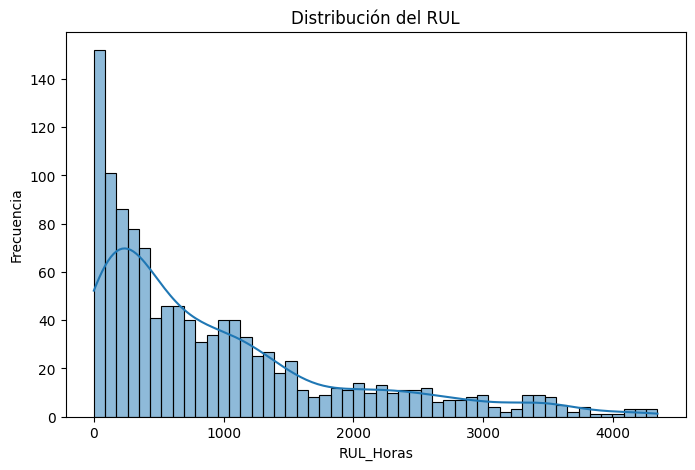

In [ ]:
# Distribución de RUL
print("\nDistribución de RUL:")
plt.figure(figsize=(8,5))
sns.histplot(data_filtrado['RUL_Horas'], bins=50, kde=True)
plt.title("Distribución del RUL")
plt.xlabel("RUL_Horas")
plt.ylabel("Frecuencia")
plt.show()

# Paso 2: Limpieza inicial de datos

In [ ]:
# La limpeza de datos lo realizaremos por equipo para evitar outliers erroneos
# Clasificación de datos por ID de quipo
# Equipo C311
C311_data = data_filtrado[data_filtrado['equipment'] == 'C311']

In [ ]:
C311_data

,equipment,fecha_telemetria,fecha_final,RUL_Horas,horometro,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Blow_by_Press_Max,...,Motor_Power_B_at_Retard_Mode_Ave,Motor_Power_B_at_Retard_Mode_Max,Motor_Torque_A_at_Retard_Mode_Ave,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,rn
1432,C311,2021-01-08 01:34:46,2021-05-05 06:41:00,2813,39255,14,28.0,3.0,58,2.0,...,750,2160.0,6640,20090.0,6640,21200.0,32000,2753,2751,1
1433,C311,2021-01-09 05:32:30,2021-05-05 06:41:00,2785,39275,14,29.0,5.0,58,2.0,...,746,2166.0,6860,21140.0,6860,20950.0,32000,2403,2435,1
1434,C311,2021-01-10 18:19:32,2021-05-05 06:41:00,2748,39295,14,28.0,5.0,57,2.0,...,758,2126.0,6950,19740.0,6940,20390.0,32000,2609,2550,1
1435,C311,2021-01-12 06:14:39,2021-05-05 06:41:00,2712,39315,15,25.0,5.0,57,2.0,...,725,2152.0,6710,19320.0,6710,19930.0,32000,2666,2642,1
1436,C311,2021-01-13 21:43:13,2021-05-05 06:41:00,2673,39335,19,31.0,9.0,58,2.0,...,837,2134.0,7460,20660.0,7460,19840.0,32000,2913,2939,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,C311,2022-03-10 05:24:09,2022-03-16 20:32:00,159,45315,16,35.0,6.0,58,1.0,...,930,2129.0,8090,19860.0,8090,19870.0,32000,2358,2344,1
1698,C311,2022-03-12 04:47:37,2022-03-16 20:32:00,112,45355,14,30.0,5.0,58,1.0,...,557,2176.0,4890,20400.0,4890,19520.0,32000,2323,2340,1
1699,C311,2022-03-14 09:24:54,2022-03-16 20:32:00,59,45395,16,31.0,4.0,59,1.0,...,0,NaN,0,NaN,0,NaN,32000,8,3,1
1700,C311,2022-03-15 09:56:07,2022-03-16 20:32:00,35,45415,17,33.0,5.0,59,1.0,...,0,NaN,0,NaN,0,NaN,32000,0,0,1


In [ ]:
C311_data.shape

(270, 59)

In [ ]:
# Resumen estadístico del equipo C311
print("\nResumen estadístico:")
display(C311_data.describe())


Resumen estadístico:


,fecha_telemetria,fecha_final,RUL_Horas,horometro,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Blow_by_Press_Max,Boost_LB_Press_Max,...,Motor_Power_B_at_Retard_Mode_Ave,Motor_Power_B_at_Retard_Mode_Max,Motor_Torque_A_at_Retard_Mode_Ave,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,rn
count,270,270,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,...,270.000000,211.000000,270.000000,211.000000,270.000000,211.000000,270.0,270.000000,270.000000,270.0
mean,2021-08-13 09:15:22.492592384,2021-10-06 02:37:46.444444416,1289.262963,42327.370370,13.714815,29.370370,3.681481,58.129630,1.777778,261.600000,...,633.640741,2185.701422,5748.259259,20515.402844,5748.111111,20368.530806,32000.0,2063.322222,2063.407407,1.0
min,2021-01-08 01:34:46,2021-05-05 06:41:00,4.000000,39255.000000,0.000000,15.000000,-12.000000,57.000000,0.000000,236.000000,...,0.000000,2052.000000,0.000000,18180.000000,0.000000,17840.000000,32000.0,0.000000,0.000000,1.0
25%,2021-04-18 15:01:22.249999872,2021-05-05 06:41:00,342.000000,40760.000000,11.000000,24.000000,2.000000,58.000000,1.000000,258.000000,...,620.000000,2142.000000,6352.500000,19995.000000,6360.000000,19820.000000,32000.0,2255.500000,2241.000000,1.0
50%,2021-08-06 16:57:06,2021-09-27 22:38:00,1112.500000,42285.000000,14.000000,29.000000,4.000000,58.000000,2.000000,262.000000,...,799.000000,2176.000000,7105.000000,20450.000000,7095.000000,20320.000000,32000.0,2560.500000,2559.000000,1.0
75%,2021-12-15 18:18:48.249999872,2022-03-08 17:39:00,2026.000000,44030.000000,17.000000,33.000000,6.000000,58.000000,2.000000,266.000000,...,850.000000,2219.000000,7637.500000,20965.000000,7637.500000,20830.000000,32000.0,2784.500000,2773.500000,1.0
max,2022-03-16 13:07:43,2022-03-16 20:32:00,3872.000000,45435.000000,23.000000,49.000000,13.000000,61.000000,3.000000,298.000000,...,1052.000000,2460.000000,9150.000000,23070.000000,9150.000000,23840.000000,32000.0,3364.000000,3403.000000,1.0
std,NaN,NaN,1058.638711,1829.463003,4.652633,6.782594,4.311568,0.623168,0.658563,5.653173,...,344.115990,66.198626,3094.840821,757.854870,3094.522524,808.692197,0.0,1115.325183,1115.593808,0.0


In [ ]:
# OBSERVACIÓN: Vamos a eliminar dos columnas para todos los equipos tratados, ya que solo existen datos en dos equipos, en los restantes
#               no existen ningún valor. Para evitar añadir un valor errorneo se tomará esta acción.

# Eliminar una sola columna
C311_data = C311_data.drop(columns=['Blow_by_Press_Max','Boost_RB_Press_Max'])

In [ ]:
C311_data.shape

(270, 57)

In [ ]:
# Reemplazar todos los ceros por NaN en toda la tabla
C311_data = C311_data.replace(0, np.nan)

In [ ]:
# Verificamos si la data tiene datos con valor cero
(C311_data == 0).sum()

,0
equipment,0
fecha_telemetria,0
fecha_final,0
RUL_Horas,0
horometro,0
Ambient_Temp_Ave,0
Ambient_Temp_Max,0
Ambient_Temp_Min,0
Atmos_Pres_Ave,0
Boost_LB_Press_Max,0


In [ ]:
# Revisar cantidad de valores nulos por columna
C311_data.isnull().sum().sort_values(ascending=False)

,0
Hoist_Press1_Max,267
BRAKE_ENERGY,258
Motor_Torque_A_at_Retard_Mode_Ave,59
Motor_Torque_B_at_Retard_Mode_Ave,59
Motor_Torque_A_at_Retard_Mode_Max,59
Motor_A_Power_Ave,59
Motor_A_Torque_Ave,59
Motor_A_Power_Max,59
Motor_A_Torque_Max,59
Motor_B_Power_Max,59


In [ ]:
# Tratamiento de datos nulos
# Reemplazar NaN por la media en ese equipo
C311_data = C311_data.fillna(C311_data.mean(numeric_only=True))

In [ ]:
C311_data.head()

,equipment,fecha_telemetria,fecha_final,RUL_Horas,horometro,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Boost_LB_Press_Max,...,Motor_Power_B_at_Retard_Mode_Ave,Motor_Power_B_at_Retard_Mode_Max,Motor_Torque_A_at_Retard_Mode_Ave,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,rn
1540,C311,2021-06-27 12:53:23,2021-07-22 14:15:00,602,41735,13.765799,17.0,-10.0,58,266,...,680.0,2163.0,7430.0,20150.0,7440.0,20250.0,32000,2223.0,2241.0,1
1573,C311,2021-08-27 08:38:22,2021-09-27 22:38:00,758,42415,1.000000,17.0,-12.0,58,262,...,897.0,2128.0,7750.0,19390.0,7730.0,19030.0,32000,2824.0,2866.0,1
1522,C311,2021-05-21 10:12:56,2021-05-22 07:33:00,21,41315,1.000000,21.0,-8.0,57,270,...,671.0,2101.0,6660.0,19480.0,6660.0,19790.0,32000,2749.0,2741.0,1
1561,C311,2021-07-27 11:52:18,2021-09-27 22:38:00,1499,42175,2.000000,17.0,-5.0,58,254,...,934.0,2202.0,7870.0,23070.0,7870.0,20170.0,32000,2746.0,2757.0,1
1569,C311,2021-08-09 03:06:36,2021-09-27 22:38:00,1195,42335,3.000000,15.0,-6.0,58,264,...,898.0,2217.0,8150.0,20310.0,8150.0,20080.0,32000,2768.0,2763.0,1


In [ ]:
# Imputar nulos usando la mediana de cada columna
C311_data = C311_data.fillna(C311_data.median(numeric_only=True))

# 4️⃣ Verificación
print("\nVerificación de nulos después de imputar:")
print(C311_data.isnull().sum().sum(), "valores nulos restantes")


Verificación de nulos después de imputar:
0 valores nulos restantes


In [ ]:
C311_data

,equipment,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Boost_LB_Press_Max,BRAKE_ENERGY,Brake_Oil_Temp_LF_Ave,Brake_Oil_Temp_LF_Max,Brake_Oil_Temp_LR_Ave,...,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,fecha_telemetria,fecha_alerta,horometro,RUL_Horas
292,C311,13.769231,17.0,-10.0,58.0,266.0,1.25,25.0,42.0,26.0,...,20150.000000,7440.000000,20250.000000,32000.0,2223.000000,2241.000000,2021-06-27 12:53:23,2021-06-27 20:16:51,41735,8.000000
1219,C311,1.000000,17.0,-12.0,58.0,262.0,1.25,21.0,50.0,22.0,...,19390.000000,7730.000000,19030.000000,32000.0,2824.000000,2866.000000,2021-08-27 08:38:22,2021-08-28 00:16:34,42415,16.000000
1207,C311,1.000000,21.0,-8.0,57.0,270.0,1.25,36.0,48.0,36.0,...,19480.000000,6660.000000,19790.000000,32000.0,2749.000000,2741.000000,2021-05-21 10:12:56,2021-05-21 10:30:19,41315,31.913208
1216,C311,2.000000,17.0,-5.0,58.0,254.0,1.25,33.0,50.0,34.0,...,23070.000000,7870.000000,20170.000000,32000.0,2746.000000,2757.000000,2021-07-27 11:52:18,2021-08-11 20:55:36,42175,369.000000
295,C311,3.000000,15.0,-6.0,58.0,264.0,1.25,40.0,50.0,41.0,...,20310.000000,8150.000000,20080.000000,32000.0,2768.000000,2763.000000,2021-08-09 03:06:36,2021-08-11 20:55:36,42335,65.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5831,C311,22.000000,33.0,10.0,59.0,258.0,1.25,50.0,60.0,50.0,...,20440.000000,7460.000000,20230.000000,32000.0,2842.000000,2913.000000,2021-02-07 18:16:51,2021-02-10 14:05:21,39695,68.000000
280,C311,22.000000,36.0,12.0,58.0,254.0,2.00,53.0,73.0,53.0,...,20570.000000,6800.000000,19540.000000,32000.0,2834.000000,2774.000000,2021-03-07 21:42:19,2021-03-07 23:55:47,40075,2.000000
5850,C311,22.000000,36.0,12.0,59.0,262.0,1.25,62.0,70.0,61.0,...,20539.488372,7363.627907,20375.767442,32000.0,2564.131222,2552.594595,2021-12-19 18:14:00,2021-12-20 03:55:08,44115,9.000000
4926,C311,22.000000,49.0,11.0,58.0,264.0,1.25,65.0,73.0,64.0,...,20539.488372,7363.627907,20375.767442,32000.0,2564.131222,2552.594595,2021-12-31 12:38:35,2021-12-31 17:47:46,44335,5.000000


In [ ]:
# Resumen estadístico del equipo C311 - después de tratar los valores nulos
print("\nResumen estadístico:")
display(C311_data.describe())


Resumen estadístico:


,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Boost_LB_Press_Max,BRAKE_ENERGY,Brake_Oil_Temp_LF_Ave,Brake_Oil_Temp_LF_Max,Brake_Oil_Temp_LR_Ave,Brake_Oil_Temp_LR_Max,...,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,fecha_telemetria,fecha_alerta,horometro,RUL_Horas
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,...,274.000000,274.000000,274.000000,274.0,274.000000,274.000000,274,274,274.000000,274.000000
mean,13.769231,29.379562,3.803030,58.131387,261.664234,1.250000,49.343066,61.014599,48.948905,58.678832,...,20539.488372,7363.627907,20375.767442,32000.0,2564.131222,2552.594595,2021-08-14 18:41:43.171532800,2021-08-16 01:32:47.952554496,42348.138686,31.913208
min,1.000000,15.000000,-12.000000,57.000000,236.000000,1.000000,20.000000,40.000000,20.000000,39.000000,...,18180.000000,4890.000000,17840.000000,32000.0,1.000000,1.000000,2020-11-15 06:19:24,2021-01-04 16:30:40,38575.000000,1.000000
25%,11.000000,24.000000,2.000000,58.000000,258.000000,1.250000,43.000000,55.000000,43.000000,53.000000,...,20140.000000,7070.000000,20002.500000,32000.0,2503.250000,2473.250000,2021-04-18 15:01:22.249999872,2021-04-19 03:07:40.500000,40760.000000,4.000000
50%,14.000000,29.000000,4.000000,58.000000,262.000000,1.250000,48.000000,59.000000,48.000000,57.000000,...,20539.488372,7363.627907,20375.767442,32000.0,2564.131222,2558.500000,2021-08-07 18:11:06,2021-08-11 20:55:36,42305.000000,9.000000
75%,17.000000,33.000000,6.000000,58.000000,266.000000,1.250000,58.750000,69.000000,57.000000,66.000000,...,20770.000000,7640.000000,20615.000000,32000.0,2780.000000,2771.250000,2021-12-17 16:17:46,2021-12-17 22:12:03.750000128,44070.000000,21.000000
max,23.000000,49.000000,13.000000,61.000000,298.000000,3.000000,66.000000,87.000000,64.000000,83.000000,...,23070.000000,9150.000000,23840.000000,32000.0,3364.000000,3403.000000,2022-03-20 01:45:08,2022-03-20 08:24:15,45495.000000,1210.000000
std,4.553492,6.740215,4.243399,0.620971,5.652031,0.124771,9.494118,8.158221,8.804612,7.500363,...,691.739443,553.379131,716.693794,0.0,445.295881,471.940897,NaN,NaN,1859.547289,94.825944


In [ ]:
C311_data_copy = C311_data.copy()

In [ ]:
C311_data_copy.head()

,equipment,fecha_telemetria,fecha_final,RUL_Horas,horometro,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Boost_LB_Press_Max,...,Motor_Power_B_at_Retard_Mode_Ave,Motor_Power_B_at_Retard_Mode_Max,Motor_Torque_A_at_Retard_Mode_Ave,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,rn
1432,C311,2021-01-08 01:34:46,2021-05-05 06:41:00,2813,39255,14.0,28.0,3.0,58,264,...,750.0,2160.0,6640.0,20090.0,6640.0,21200.0,32000,2753.0,2751.0,1
1433,C311,2021-01-09 05:32:30,2021-05-05 06:41:00,2785,39275,14.0,29.0,5.0,58,264,...,746.0,2166.0,6860.0,21140.0,6860.0,20950.0,32000,2403.0,2435.0,1
1434,C311,2021-01-10 18:19:32,2021-05-05 06:41:00,2748,39295,14.0,28.0,5.0,57,266,...,758.0,2126.0,6950.0,19740.0,6940.0,20390.0,32000,2609.0,2550.0,1
1435,C311,2021-01-12 06:14:39,2021-05-05 06:41:00,2712,39315,15.0,25.0,5.0,57,276,...,725.0,2152.0,6710.0,19320.0,6710.0,19930.0,32000,2666.0,2642.0,1
1436,C311,2021-01-13 21:43:13,2021-05-05 06:41:00,2673,39335,19.0,31.0,9.0,58,274,...,837.0,2134.0,7460.0,20660.0,7460.0,19840.0,32000,2913.0,2939.0,1


In [ ]:
C311_data_copy = C311_data_copy.iloc[:,3:]

In [ ]:
C311_data_copy.drop(columns=['rn'])

,RUL_Horas,horometro,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Boost_LB_Press_Max,BRAKE_ENERGY,Brake_Oil_Temp_LF_Ave,Brake_Oil_Temp_LF_Max,...,Motor_Power_A_at_Retard_Mode_Max,Motor_Power_B_at_Retard_Mode_Ave,Motor_Power_B_at_Retard_Mode_Max,Motor_Torque_A_at_Retard_Mode_Ave,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max
1432,2813,39255,14.0,28.0,3.0,58,264,1.25,44,56,...,2163.00000,750.000000,2160.000000,6640.000000,20090.000000,6640.000000,21200.000000,32000,2753.000000,2751.00000
1433,2785,39275,14.0,29.0,5.0,58,264,1.25,44,53,...,2148.00000,746.000000,2166.000000,6860.000000,21140.000000,6860.000000,20950.000000,32000,2403.000000,2435.00000
1434,2748,39295,14.0,28.0,5.0,57,266,1.25,45,58,...,2128.00000,758.000000,2126.000000,6950.000000,19740.000000,6940.000000,20390.000000,32000,2609.000000,2550.00000
1435,2712,39315,15.0,25.0,5.0,57,276,1.25,45,54,...,2139.00000,725.000000,2152.000000,6710.000000,19320.000000,6710.000000,19930.000000,32000,2666.000000,2642.00000
1436,2673,39335,19.0,31.0,9.0,58,274,1.25,45,62,...,2156.00000,837.000000,2134.000000,7460.000000,20660.000000,7460.000000,19840.000000,32000,2913.000000,2939.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,159,45315,16.0,35.0,6.0,58,266,1.25,62,75,...,2099.00000,930.000000,2129.000000,8090.000000,19860.000000,8090.000000,19870.000000,32000,2358.000000,2344.00000
1698,112,45355,14.0,30.0,5.0,58,266,1.25,59,71,...,2089.00000,557.000000,2176.000000,4890.000000,20400.000000,4890.000000,19520.000000,32000,2323.000000,2340.00000
1699,59,45395,16.0,31.0,4.0,59,266,1.25,56,70,...,2166.63981,810.819905,2185.701422,7355.592417,20515.402844,7355.402844,20368.530806,32000,8.000000,3.00000
1700,35,45415,17.0,33.0,5.0,59,262,1.25,53,67,...,2166.63981,810.819905,2185.701422,7355.592417,20515.402844,7355.402844,20368.530806,32000,2567.267281,2555.59633


In [ ]:
# Tratamiento de outliers
# Reemplazar todos los NaN por 0
t = t.fillna(0)

for col in t.select_dtypes(include=[np.number]).columns:
    Q1 = t[col].quantile(0.25)
    Q3 = t[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Reemplazar outliers por NaN
    t[col] = t[col].mask((t[col] < lower_limit) | (t[col] > upper_limit), np.nan)

# Si quieres luego reemplazar por la mediana:
t = t.fillna(t.median(numeric_only=True))

t

In [ ]:
# Función para visualizar la diferencia entre outlier

def comparar_variable_boxplot(df_original, df_tratada, variable):
    plt.figure(figsize=(8, 5))
    plt.boxplot(
        [df_original[variable].dropna(), df_tratada[variable].dropna()],
        labels=["Original", "Tratada"]
    )
    plt.title(f"Comparación de {variable}")
    plt.ylabel(variable)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

/tmp/ipython-input-1458627279.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


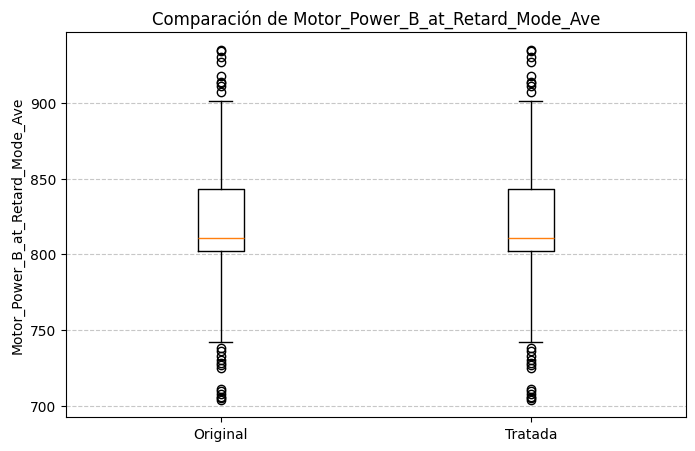

In [ ]:
# LLamado de la función
variable_type=C311_data_copy.select_dtypes(include=['number']).columns.tolist()

comparar_variable_boxplot(C311_data_copy, C311_data_copy, random.choice(variable_type))

In [ ]:
C311_data_copy

,RUL_Horas,horometro,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Boost_LB_Press_Max,BRAKE_ENERGY,Brake_Oil_Temp_LF_Ave,Brake_Oil_Temp_LF_Max,...,Motor_Power_B_at_Retard_Mode_Ave,Motor_Power_B_at_Retard_Mode_Max,Motor_Torque_A_at_Retard_Mode_Ave,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,rn
1540,602,41735,13.765799,17.0,4.0,58.0,266.0,1.25,25,42,...,810.819905,2163.000000,7430.000000,20150.000000,7440.000000,20250.000000,32000,2223.000000,2241.00000,1
1573,758,42415,14.000000,17.0,4.0,58.0,262.0,1.25,21,50,...,897.000000,2128.000000,7750.000000,19390.000000,7730.000000,20368.530806,32000,2824.000000,2866.00000,1
1522,21,41315,14.000000,21.0,4.0,58.0,270.0,1.25,36,48,...,810.819905,2101.000000,6660.000000,19480.000000,6660.000000,19790.000000,32000,2749.000000,2741.00000,1
1561,1499,42175,2.000000,17.0,4.0,58.0,254.0,1.25,33,50,...,934.000000,2202.000000,7870.000000,20515.402844,7870.000000,20170.000000,32000,2746.000000,2757.00000,1
1569,1195,42335,3.000000,15.0,4.0,58.0,264.0,1.25,40,50,...,898.000000,2217.000000,8150.000000,20310.000000,8150.000000,20080.000000,32000,2768.000000,2763.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,1370,40095,22.000000,33.0,4.0,58.0,258.0,1.25,50,61,...,708.000000,2112.000000,6480.000000,19670.000000,6490.000000,19830.000000,32000,2629.000000,2578.00000,1
1471,1401,40075,22.000000,36.0,12.0,58.0,254.0,1.25,53,73,...,760.000000,2147.000000,6780.000000,20570.000000,6800.000000,19540.000000,32000,2834.000000,2774.00000,1
1638,1895,44115,22.000000,36.0,12.0,58.0,262.0,1.25,62,70,...,810.819905,2185.701422,7355.592417,20515.402844,7355.402844,20368.530806,32000,2567.267281,2555.59633,1
1648,1613,44335,22.000000,29.0,11.0,58.0,264.0,1.25,65,73,...,810.819905,2185.701422,7355.592417,20515.402844,7355.402844,20368.530806,32000,2567.267281,2555.59633,1


In [ ]:
# correlación
C311_data_copy.corr()["RUL_Horas"].sort_values(ascending=False)

,RUL_Horas
RUL_Horas,1.000000
Engine_Coolant_Temp_Max,0.282615
Boost_LB_Press_Max,0.279675
Motor_B_Power_Ave,0.264187
Motor_A_Power_Ave,0.211550
Brake_Oil_Temp_RF_Ave,0.185979
Brake_Oil_Temp_LF_Ave,0.183813
DC_Power_Ave,0.179339
Brake_Oil_Temp_RR_Ave,0.178835
Brake_Oil_Temp_LR_Ave,0.177701


In [ ]:
# Detectamos reinicio: cuando RUL actual > RUL anterior
C311_data_copy["nuevo_ciclo"] = (C311_data_copy["RUL_Horas"] > C311_data_copy["RUL_Horas"].shift()).astype(int)

# Creamos ciclo_id acumulando los reinicios
C311_data_copy["ciclo_id"] = C311_data_copy["nuevo_ciclo"].cumsum() + 1

In [ ]:
C311_data_copy

,RUL_Horas,horometro,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Boost_LB_Press_Max,BRAKE_ENERGY,Brake_Oil_Temp_LF_Ave,Brake_Oil_Temp_LF_Max,...,Motor_Torque_A_at_Retard_Mode_Ave,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,rn,nuevo_ciclo,ciclo_id
1432,2813,39255,14.0,28.0,3.0,58,264,1.25,44,56,...,6640.000000,20090.000000,6640.000000,21200.000000,32000,2753.000000,2751.00000,1,0,1
1433,2785,39275,14.0,29.0,5.0,58,264,1.25,44,53,...,6860.000000,21140.000000,6860.000000,20950.000000,32000,2403.000000,2435.00000,1,0,1
1434,2748,39295,14.0,28.0,5.0,57,266,1.25,45,58,...,6950.000000,19740.000000,6940.000000,20390.000000,32000,2609.000000,2550.00000,1,0,1
1435,2712,39315,15.0,25.0,5.0,57,276,1.25,45,54,...,6710.000000,19320.000000,6710.000000,19930.000000,32000,2666.000000,2642.00000,1,0,1
1436,2673,39335,19.0,31.0,9.0,58,274,1.25,45,62,...,7460.000000,20660.000000,7460.000000,19840.000000,32000,2913.000000,2939.00000,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,159,45315,16.0,35.0,6.0,58,266,1.25,62,75,...,8090.000000,19860.000000,8090.000000,19870.000000,32000,2358.000000,2344.00000,1,0,8
1698,112,45355,14.0,30.0,5.0,58,266,1.25,59,71,...,4890.000000,20400.000000,4890.000000,19520.000000,32000,2323.000000,2340.00000,1,0,8
1699,59,45395,16.0,31.0,4.0,59,266,1.25,56,70,...,7355.592417,20515.402844,7355.402844,20368.530806,32000,8.000000,3.00000,1,0,8
1700,35,45415,17.0,33.0,5.0,59,262,1.25,53,67,...,7355.592417,20515.402844,7355.402844,20368.530806,32000,2567.267281,2555.59633,1,0,8


In [ ]:
data_filtrado = data_filtrado.sort_values(by=['equipment','fecha_telemetria'],ascending=[True, True])

In [ ]:
data_filtrado

,equipment,fecha_telemetria,fecha_final,RUL_Horas,horometro,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Blow_by_Press_Max,...,Motor_Power_B_at_Retard_Mode_Ave,Motor_Power_B_at_Retard_Mode_Max,Motor_Torque_A_at_Retard_Mode_Ave,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,rn
1432,C311,2021-01-08 01:34:46,2021-05-05 06:41:00,2813,39255,14,28.0,3.0,58,2.0,...,750,2160.0,6640,20090.0,6640,21200.0,32000,2753,2751,1
1433,C311,2021-01-09 05:32:30,2021-05-05 06:41:00,2785,39275,14,29.0,5.0,58,2.0,...,746,2166.0,6860,21140.0,6860,20950.0,32000,2403,2435,1
1434,C311,2021-01-10 18:19:32,2021-05-05 06:41:00,2748,39295,14,28.0,5.0,57,2.0,...,758,2126.0,6950,19740.0,6940,20390.0,32000,2609,2550,1
1435,C311,2021-01-12 06:14:39,2021-05-05 06:41:00,2712,39315,15,25.0,5.0,57,2.0,...,725,2152.0,6710,19320.0,6710,19930.0,32000,2666,2642,1
1436,C311,2021-01-13 21:43:13,2021-05-05 06:41:00,2673,39335,19,31.0,9.0,58,2.0,...,837,2134.0,7460,20660.0,7460,19840.0,32000,2913,2939,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5713,C333,2022-03-13 11:08:24,2022-04-23 03:51:00,976,17208,14,29.0,4.0,61,NaN,...,781,2265.0,7320,21410.0,7320,22080.0,20230,2660,2625,1
5714,C333,2022-03-15 04:41:47,2022-04-23 03:51:00,935,17228,13,30.0,5.0,61,NaN,...,737,2248.0,6930,20450.0,6940,19860.0,20440,2242,2171,1
5715,C333,2022-03-16 04:52:40,2022-04-23 03:51:00,911,17248,18,31.0,7.0,61,NaN,...,882,2269.0,7690,21690.0,7700,23900.0,20145,2587,2556,1
5716,C333,2022-03-17 16:23:37,2022-04-23 03:51:00,875,17268,12,27.0,3.0,60,NaN,...,913,2321.0,8680,21730.0,8690,22680.0,20483,2449,2367,1


In [ ]:
t

,RUL_Horas,horometro,Ambient_Temp_Max,Blow_by_Press_Max,Boost_LB_Press_Max,Brake_Oil_Temp_RF_Max,Engine_Coolant_Temp_Max,Exhaust_Temp_Max_RR,Motor_B_Power_Ave,Ciclo
1432,2813,39255,28.0,2.0,264,56,84,662,554,1
1433,2785,39275,29.0,2.0,264,53,83,646,590,1
1434,2748,39295,28.0,2.0,266,58,83,655,592,1
1435,2712,39315,25.0,2.0,276,54,83,651,625,1
1436,2673,39335,31.0,2.0,274,62,83,660,608,1
...,...,...,...,...,...,...,...,...,...,...
1697,159,45315,35.0,1.0,266,74,89,642,699,8
1698,112,45355,30.0,1.0,266,70,88,637,533,8
1699,59,45395,31.0,1.0,266,69,88,644,0,8
1700,35,45415,33.0,1.0,262,67,88,652,0,8


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

X = C311_data_copy.drop(columns=["RUL_Horas"])
y = C311_data_copy["RUL_Horas"]

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X, y)

importances = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)



In [ ]:
importances.head(50)

,feature,importance
0,horometro,0.582995
22,Engine_Coolant_Temp_Max,0.165921
54,ciclo_id,0.073534
5,Boost_LB_Press_Max,0.048458
29,Exhaust_Temp_Max_RR,0.023747
12,Brake_Oil_Temp_RF_Max,0.007444
39,Motor_B_Power_Ave,0.007074
16,DC_Power_Ave,0.007016
32,Hoist_Press2_Max,0.004923
24,Engine_Oil_Filter_Differential_Pressure,0.004880


# MACHING LEARNIG

## random forest

In [ ]:
t = data_C311[['RUL_Horas','horometro','Boost_LB_Press_Max',
               'Engine_Coolant_Temp_Max','Exhaust_Temp_Max_RR','Ciclo']]

In [ ]:
# Dividimos las variables

# Seleccionar solo columnas numéricas
numeric_cols = t.select_dtypes(include=['number']).columns

# Eliminar 'RUL' y 'horometro' de X
X = t[numeric_cols].drop(columns=['RUL_Horas'], errors='ignore')
y = t["RUL_Horas"]

In [ ]:
# Dividir en train y test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [ ]:
# Entrenar Random Forest
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
# Hacer predicciones
y_pred = model.predict(X_test)

In [ ]:
# Evaluar métricas

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


MAE: 128.60
MSE: 129251.27
RMSE: 359.52
R²: 0.8695


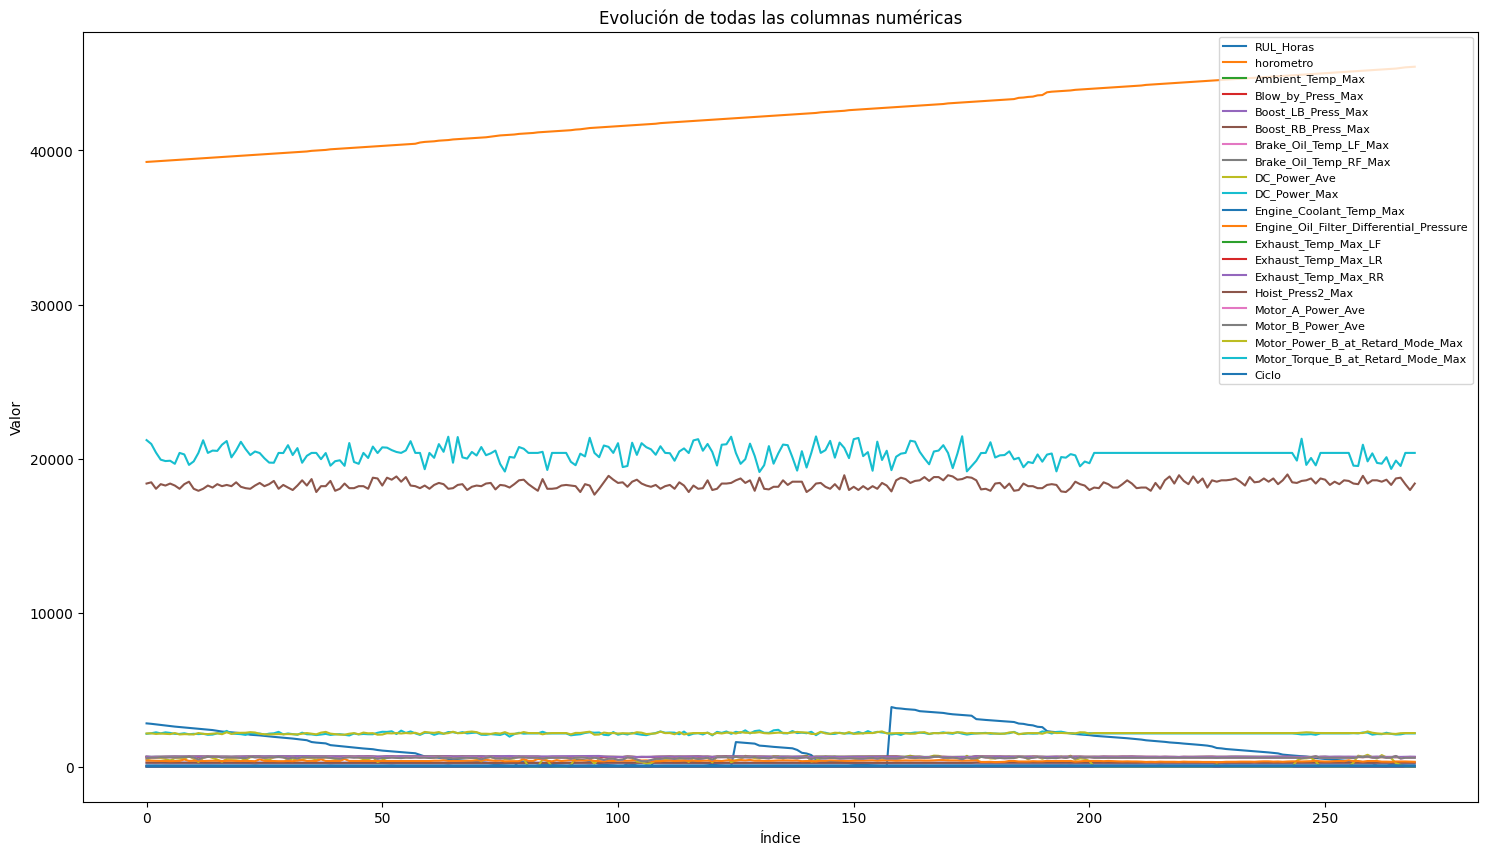

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que tu DataFrame se llama "data"
plt.figure(figsize=(18,10))

# Graficar cada columna numérica
for col in t.columns:
    if pd.api.types.is_numeric_dtype(t[col]):  # solo columnas numéricas
        plt.plot(range(len(t)), t[col].values, label=col)

plt.xlabel("Índice")
plt.ylabel("Valor")
plt.title("Evolución de todas las columnas numéricas")
plt.legend(loc='upper right', fontsize=8)
plt.show()



In [ ]:
print('Reales: ',y_test[:5], 'Predicción: ',y_pred[:5])


Reales:  1462    1858
1548     297
1511     357
1559    1548
1628    2170
Name: RUL_Horas, dtype: int64 Predicción:  [1870.64   505.15   272.43  1271.565 2181.37 ]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np

# Modelo base
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Definimos la grilla de hiperparámetros
param_grid = {
    "n_estimators": [200, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    verbose=2,
    n_jobs=-1
)

# Entrenamos
grid_search.fit(X_train, y_train)

# Imprimir mejores hiperparámetros y R² de validación
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor R² en validación:", grid_search.best_score_)

# Predecir en conjunto de test usando el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE calculado manualmente
r2 = r2_score(y_test, y_pred)

print("\nMétricas en el conjunto de test:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# Comparación de algunos valores reales vs predicciones
print("\nComparación de valores reales vs. predicciones:")
for real, pred in zip(y_test[:5], y_pred[:5]):
    print(f"Real: {real:.2f}, Predicción: {pred:.2f}")



Fitting 3 folds for each of 324 candidates, totalling 972 fits
Mejores parámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500, 'subsample': 1.0}
Mejor R² en validación: 0.9303217728932699

Métricas en el conjunto de test:
MAE:  178.70
MSE:  301390.97
RMSE: 548.99
R²:   0.6956

Comparación de valores reales vs. predicciones:
Real: 1858.00, Predicción: 1841.49
Real: 297.00, Predicción: 436.51
Real: 357.00, Predicción: 260.70
Real: 1548.00, Predicción: 1235.39
Real: 2170.00, Predicción: 2252.72


Según las métricas, nuestro modelo no ayuda en nada, es pésimo en la predicción, vamos a mejorarlo.

In [ ]:
print('Reales: ',y_test[:5], 'Predicción: ',y_pred[:5])

Reales:  1462    1858
1548     297
1511     357
1559    1548
1628    2170
Name: RUL_Horas, dtype: int64 Predicción:  [1790.0962   289.80508  242.90692 1177.0101  2251.3655 ]


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Modelo base
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Definimos la grilla de hiperparámetros
param_grid = {
    "n_estimators": [200, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,  # k-fold cross-validation
    scoring="r2",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor R² en validación:", grid_search.best_score_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Mejores parámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 800, 'subsample': 1.0}
Mejor R² en validación: 0.9283890525499979


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# El mejor modelo ya entrenado con GridSearchCV
best_model = grid_search.best_estimator_

# Predicciones sobre el conjunto de test
y_pred_test = best_model.predict(X_test)

# Métricas en test
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("Métricas en conjunto de test:")
print(f"MAE:  {mae_test:.2f}")
print(f"MSE:  {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R²:   {r2_test:.4f}")

# Comparación R² de validación vs R² de test
print("\nComparación R²:")
print(f"R² en validación (GridSearchCV): {grid_search.best_score_:.4f}")
print(f"R² en test (desempeño real):      {r2_test:.4f}")

# Mostrar primeros 5 valores reales vs predichos
print("\nPrimeros 5 valores reales vs predicciones:")
for real, pred in zip(y_test[:5], y_pred_test[:5]):
    print(f"Real: {real:.2f}, Predicción: {pred:.2f}")


Métricas en conjunto de test:
MAE:  185.41
MSE:  297887.22
RMSE: 545.79
R²:   0.6991

Comparación R²:
R² en validación (GridSearchCV): 0.9284
R² en test (desempeño real):      0.6991

Primeros 5 valores reales vs predicciones:
Real: 1858.00, Predicción: 1794.18
Real: 297.00, Predicción: 425.38
Real: 357.00, Predicción: 277.98
Real: 1548.00, Predicción: 1217.08
Real: 2170.00, Predicción: 2222.31


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Entrenamos el modelo con los mejores parámetros encontrados
best_model = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=4,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42
)

best_model.fit(X_train, y_train)

# Predicción en el conjunto de test
y_pred_best = best_model.predict(X_test)

# Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred_best)
mse = mean_squared_error(y_test, y_pred_best)
rmse = np.sqrt(mse)  # RMSE calculado manualmente
r2 = r2_score(y_test, y_pred_best)

print("Resultados modelo optimizado:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")



Resultados modelo optimizado:
MAE:  185.41
MSE:  297887.22
RMSE: 545.79
R²:   0.6991


In [ ]:
# Evaluar métricas

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 195.66
MSE: 270580.44
RMSE: 520.17
R²: 0.7267


/tmp/ipython-input-983369781.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")


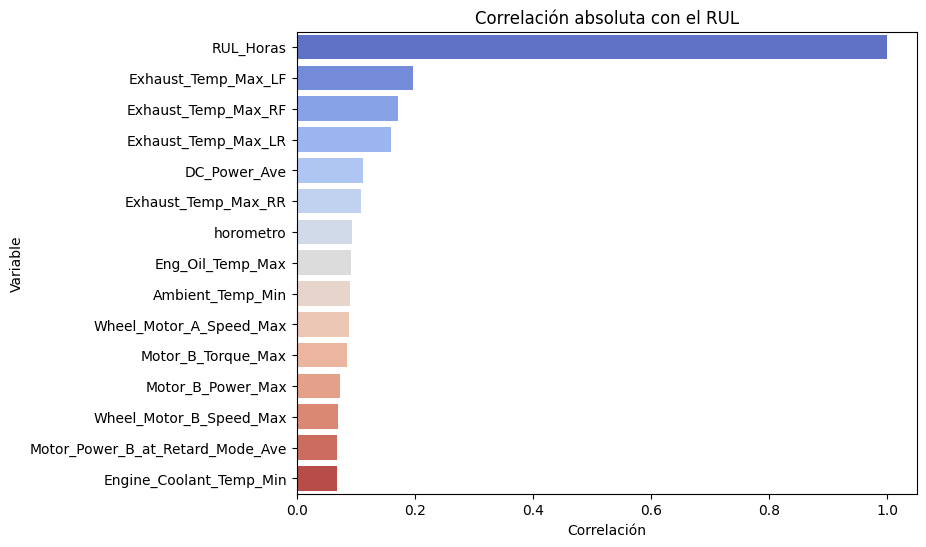

,RUL_Horas
RUL_Horas,1.000000
Exhaust_Temp_Max_LF,0.196662
Exhaust_Temp_Max_RF,0.172079
Exhaust_Temp_Max_LR,0.159803
DC_Power_Ave,0.111577
Exhaust_Temp_Max_RR,0.108666
Wheel_Motor_A_Speed_Max,0.089425
Wheel_Motor_B_Speed_Max,0.070141
Motor_Power_B_at_Retard_Mode_Ave,0.067782
Engine_Coolant_Temp_Min,0.067568


In [ ]:
# Paso 1 — Analizar correlación con el RUL
# Antes de tocar el modelo, necesitamos saber qué variables realmente aportan información.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular correlación de todas las variables con el RUL
correlations = C311_data.corr(numeric_only=True)['RUL_Horas'].sort_values(ascending=False)

# Mostrar las 15 más correlacionadas (positiva y negativamente)
top_corr = correlations.abs().sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")
plt.title("Correlación absoluta con el RUL")
plt.xlabel("Correlación")
plt.ylabel("Variable")
plt.show()

correlations.head(15)


In [ ]:
# Paso 2 — Selección de variables
# Usar solo las más relevantes ayuda a reducir ruido:
# Tomar las 15 variables más correlacionadas con RUL
selected_features = top_corr.index.drop('RUL_Horas')
X = C311_data[selected_features]
y = C311_data['RUL_Horas']


In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Lista de modelos a probar
modelos = {
    "XGBoost": XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "CatBoost": CatBoostRegressor(n_estimators=200, random_state=42, verbose=0)
}

resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    resultados.append([nombre, mae, mse, rmse, r2])

# Mostrar resultados en tabla
import pandas as pd
df_resultados = pd.DataFrame(resultados, columns=["Modelo", "MAE", "MSE", "RMSE", "R²"])
print(df_resultados)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 20
[LightGBM] [Info] Start training from score 1297.550926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [ ]:
# Tratamiento de outliers

for col in data_C311.select_dtypes(include=[np.number]).columns:
    Q1 = data_C311[col].quantile(0.25)
    Q3 = data_C311[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Reemplazar outliers por NaN
    data_C311[col] = data_C311[col].mask((data_C311[col] < lower_limit) | (data_C311[col] > upper_limit), np.nan)

# Si quieres luego reemplazar por la mediana:
data_C311 = data_C311.fillna(data_C311.median(numeric_only=True))

In [ ]:
t=t[['RUL_Horas', 'horometro','Ciclo','Engine_Oil_Filter_Differential_Pressure','Eng_Oil_Press_Lo_Idle_Min',
 'Eng_Oil_Press_Hi_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max','Exhaust_Temp_Max_RF',
 'Exhaust_Temp_Max_LF','Exhaust_Temp_Max_RR','Exhaust_Temp_Max_LR','Blow_by_Press_Max','Motor_A_Power_Max',
 'Motor_B_Power_Max','DC_Power_Ave','Motor_A_Power_Ave','Motor_B_Power_Ave','DC_Power_Ave','Motor_A_Torque_Max','Motor_B_Torque_Max',
 'Motor_A_Torque_Ave','Motor_B_Torque_Ave','Motor_Power_A_at_Retard_Mode_Max','Motor_Power_B_at_Retard_Mode_Max',
 'Motor_Torque_A_at_Retard_Mode_Max','Motor_Torque_B_at_Retard_Mode_Max']]

In [ ]:
# Tratamiento de outliers
# Reemplazar todos los NaN por 0
t = t.fillna(0)

for col in t.select_dtypes(include=[np.number]).columns:
    Q1 = t[col].quantile(0.25)
    Q3 = t[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Reemplazar outliers por NaN
    t[col] = t[col].mask((t[col] < lower_limit) | (t[col] > upper_limit), np.nan)

# Si quieres luego reemplazar por la mediana:
t = t.fillna(t.median(numeric_only=True))

t